In [182]:
from collections import Counter
from itertools import combinations

import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.graph_utils as graph_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.misc.cpg_const as cpg_const
from matching.glema.common.model import InferenceGNN

In [2]:
args = arg_utils.parse_args( use_default=True )

args.dataset = "CPG_augm_large"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )

args = arg_utils.load_args( args, model_name )
args.iso = True
args.test_data = True

In [3]:
model = InferenceGNN( args )

Loading model from /Users/jeanjour/Documents/projects/python/dpd-subgraph-matching/matching/glema/training/save/CPG_augm_large_undirected_anchored_v1/model.pt ...


In [100]:
def predict( model, G_source, G_query ) -> float:
    results = model.predict_label( [ G_query ], [ G_source ] )
    return results[ 0 ].item()


def predict_bulk( model, G_sources, G_queries ) -> list[ float ]:
    return model.predict_label( G_queries, G_sources ).cpu().detach().numpy()


def is_subgraph( model, G_source, G_query, conf=0.5 ) -> bool:
    prediction = predict( model, G_source, G_query )
    is_sub = prediction > conf
    print( f"query is subgraph of source: {is_sub} [{prediction:.3}]" )
    return is_sub

In [5]:
record_scopes = graph_utils.get_record_scopes( args )
design_patterns = graph_utils.get_design_patterns( args )
label_args = {
    "record_scopes": record_scopes,
    "design_patterns": design_patterns
}

In [6]:
source_graphs = graph_utils.load_source_graphs( args )
pattern_graphs = graph_utils.get_pattern_graphs( args, source_graphs )
{ dp.value: len( l ) for dp, l in pattern_graphs.items() }

{'OBSERVER': 83,
 'FACTORY_METHOD': 49,
 'BUILDER': 25,
 'ADAPTER': 13,
 'SINGLETON': 5,
 'FACADE': 7,
 'ABSTRACT_FACTORY': 16}

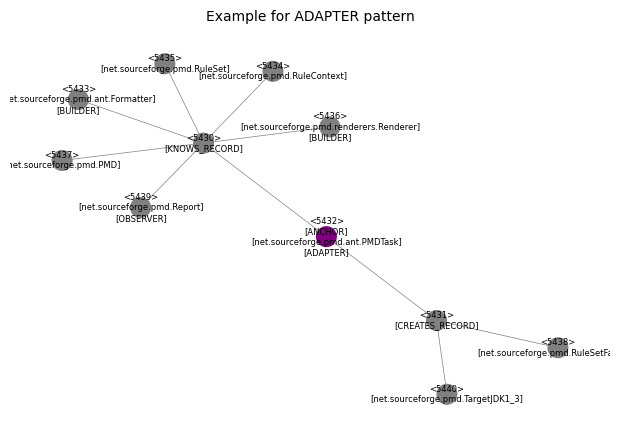

In [7]:
dp_target = cpg_const.DesignPatternType.ADAPTER
dp_target_graph = pattern_graphs[ dp_target ][ 2 ]

plot_utils.plot_graph( dp_target_graph,
                       title=f"Example for {dp_target.value} pattern",
                       nodeColors=graph_utils.get_node_colors( dp_target_graph ),
                       nodeLabels=graph_utils.get_node_labels( dp_target_graph, **label_args ) )

In [194]:
def compute_connected_subgraphs( G, a, n_min=-1, n_max=-1, total_max=-1 ):
    bfs_nodes = list( nx.bfs_tree( G, source=a ).nodes )
    subgraphs = [ ]
    if n_max < 0:
        n_max = len( bfs_nodes )
    for size in range( max( n_min, 1 ), n_max + 1 ):
        for subset in combinations( bfs_nodes, size ):
            subgraph = G.subgraph( subset )
            if nx.is_connected( subgraph ) and a in subgraph.nodes:
                subgraphs.append( subgraph.copy() )
                if total_max > 0 and len( subgraphs ) >= total_max:
                    return subgraphs

    return subgraphs

def has_pattern( model, graph, pattern_graphs, pattern_type,
                 conf=0.5, max_samples=20, bulk_size=128, subgraph_relation=3, query_graph=False ):
    preds = [ ]
    pattern_type_queries = pattern_graphs[ pattern_type ]
    for query in pattern_type_queries[ :max_samples ]:

        target_graph = query if query_graph else graph
        target_query = graph if query_graph else query
        max_subgraph_size = target_graph.number_of_nodes() // subgraph_relation
        queries = compute_connected_subgraphs( target_query, graph_utils.get_anchor( target_query ),
                                               n_min=2, n_max=max_subgraph_size, total_max=bulk_size )
        queries = queries[ :bulk_size ]
        sources = [ target_graph for _ in list( range( len( queries ) ) ) ]

        if len( queries ) == 0:
            continue

        query_preds = predict_bulk( model, sources, queries )
        query_preds = np.array( sorted( query_preds ) )

        # simple voting
        query_preds_pos = sum( p > conf for p in query_preds )
        query_preds_neg = sum( p <= conf for p in query_preds )
        query_pred = 1.0 if query_preds_pos > query_preds_neg else 0.0
        preds.append( query_pred )

        # calc inter-quantile range measurement
        #q = 0.1
        #query_q = np.quantile( query_preds, 1-q ) - np.quantile( query_preds, q )
        #preds.append( query_q )

        #query_mean = np.mean( query_preds )
        #preds.append( query_mean )

    preds = np.array( preds )
    mean = np.mean( preds )
    """
    median = np.median( preds )
    var = np.var( preds )
    std = np.std( preds )
    maxp = np.max( preds )
    print(
        f"Total predictions is {mean > conf}: mean[{mean:.3}] median[{median:.3}] var[{var:.3}] std[{std:.3}] max[{maxp:.3}]" )
    """
    return mean

In [195]:
source_graph = pattern_graphs[ cpg_const.DesignPatternType.FACTORY_METHOD ][ 0 ]
predictions = { }
for pattern in tqdm( pattern_graphs.keys() ):
    pred = has_pattern( model, source_graph, pattern_graphs, pattern, query_graph=True )
    predictions[ pattern.value ] = pred

predictions = { k: round( float( v ), 3 ) for k, v in sorted( predictions.items(), key=lambda item: item[ 1 ] ) }
predictions

100%|██████████| 7/7 [00:09<00:00,  1.35s/it]


{'BUILDER': 0.0,
 'SINGLETON': 0.0,
 'FACADE': 0.0,
 'ABSTRACT_FACTORY': 0.0,
 'FACTORY_METHOD': 0.05,
 'OBSERVER': 0.105,
 'ADAPTER': 0.182}

In [196]:
true_labels = []
pred_labels = []
conf = 0.0
for source_pattern_type in pattern_graphs.keys():
    for source_pattern in tqdm( pattern_graphs[source_pattern_type][:3] ):
        best_pred = 0.0
        pattern_type_pred = "N/A"
        for query_pattern_type in pattern_graphs.keys():
            pred = has_pattern( model, source_pattern, 
                                pattern_graphs, query_pattern_type, 
                                conf=conf, max_samples=3, bulk_size=64, query_graph=True )
            if pred > best_pred and pred > conf:
                best_pred = pred
                pattern_type_pred = query_pattern_type.value
        true_labels.append( source_pattern_type.value )
        pred_labels.append( pattern_type_pred )

100%|██████████| 7/7 [00:01<00:00,  3.87it/s]


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'N/A'),
  Text(0, 1, 'ABSTRACT_FACTORY'),
  Text(0, 2, 'ADAPTER'),
  Text(0, 3, 'BUILDER'),
  Text(0, 4, 'FACADE'),
  Text(0, 5, 'FACTORY_METHOD'),
  Text(0, 6, 'OBSERVER'),
  Text(0, 7, 'SINGLETON')])

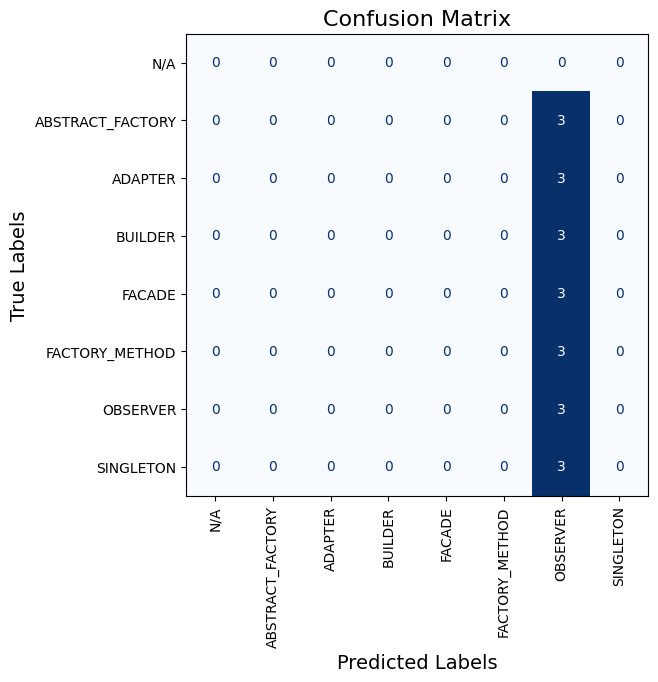

In [197]:
labels = [ "N/A", *[e.value for e in cpg_const.DesignPatternType] ]
cm = confusion_matrix(true_labels, pred_labels, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(6, 6))  # Set figure size
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

plt.title("Confusion Matrix", fontsize=16)  # Title font size
plt.xlabel("Predicted Labels", fontsize=14)  # X-axis label font size
plt.ylabel("True Labels", fontsize=14)  # Y-axis label font size
plt.xticks(fontsize=10, rotation=90)  # X-axis tick labels font size
plt.yticks(fontsize=10)  # Y-axis tick labels font size